In [1]:
# If external python files are updated
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

import functions

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


# Data preprocessing


### Hyperparameters for data importation

In [2]:
train_size = 0.75                    # In percent
test_size = 1 - train_size           # In percent, calculated dynamically from train_size
batch_size = 32                      # Size of batches

## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

In [3]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for path in folder_paths:
    c = folder_paths.index(path)
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy arrayF
X = np.array(X)

from sklearn.preprocessing import Normalizer
# Transpose to make each image a row

X = X.reshape(X.shape[0], -1)

# Normalize each row (i.e., each flattened image)
X = Normalizer().fit_transform(X)

# Reshape back to the original shape
X = X.reshape(len(X), 128, 128, 1)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

X.shape

(6400, 128, 128, 1)

### Split into Test/Training sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1 - train_size, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1 - train_size, stratify=Y_train, random_state=42)

for i in np.unique(Y_train):
    print(f"Elements of {i} in X_train: {np.count_nonzero(Y_train == i)}")
print()
for i in np.unique(Y_test):
    print(f"Elements of {i} in X_test: {np.count_nonzero(Y_test == i)}")
print()
for i in np.unique(Y_val):
    print(f"Elements of {i} in X_val: {np.count_nonzero(Y_val == i)}")

Elements of 0 in X_train: 1800
Elements of 1 in X_train: 1260
Elements of 2 in X_train: 504
Elements of 3 in X_train: 36

Elements of 0 in X_test: 800
Elements of 1 in X_test: 560
Elements of 2 in X_test: 224
Elements of 3 in X_test: 16

Elements of 0 in X_val: 600
Elements of 1 in X_val: 420
Elements of 2 in X_val: 168
Elements of 3 in X_val: 12


In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.Y[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label

transformation = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

# Create an instance of your dataset
dataset_train = MyDataset(X=X_train, Y=Y_train, transform=transformation)
dataset_val = MyDataset(X=X_val, Y=Y_val, transform=transformation)
dataset_test = MyDataset(X=X_test, Y=Y_test, transform=transformation)

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

### Show example of dataset

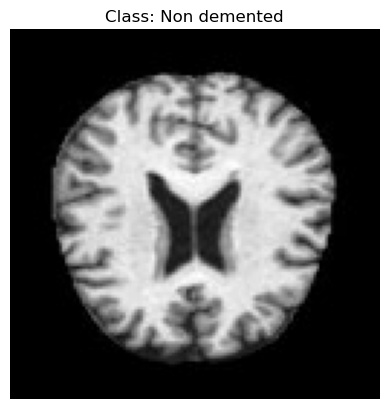

In [6]:
index_to_display = 0  # Image to show in dataset

# Get the image array and corresponding class
selected_image = X[index_to_display]
selected_class = classes[Y[index_to_display]]

# Display the image
plt.imshow(selected_image, cmap='gray')
plt.title(f'Class: {selected_class}')
plt.axis('off')  # Turn off axis labels
plt.show()

## Data augmentation

## Data normalization

# Architecture of the network

### Hyperparameters Network

In [7]:
# training
num_epochs = 200                         # Number of epochs for the training of the nn

# Learning rate und scheduler
initial_learning_rate = 0.001            # Learningrate at start
lr_steps = 15                         # Steps in lr scheduler until lr is updated
lr_gamma = 0.5                          # Faktor the lr is multiplied and updated with

In [8]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)                        # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [54]:
dynamic_model = functions.custom_ConvNet(
    input_channels = 1,
    output_size = 4,
    n_conv_layers1 = 4,
    n_filters1 = 6,
    kernel_size1 = 8,
    n_dense_layers = 6,
    n_dense_initial_nodes = 2**10,
    n_conv_layers2 = 3,
    n_filters2 = 4, 
    kernel_size2 = 3,
    operation_and_factor_filter_size=('*', 2),
    operation_and_factor_dense_network=('/', 2),
    dropout_rate=0.1,
    pooling = [2,2],
    nb_pooling_layers=2,
    activation_function = F.leaky_relu,
    )

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)
dynamic_model.apply(init_weights)

criterion = FocalLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)
early_stopper = functions.EarlyStopper(dynamic_model, patience=5, min_delta=0.05)

loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(dynamic_model, train_loader, criterion, optimizer, num_epochs, lr_scheduler, test_loader, device, early_stopper=early_stopper)

Size last layer before output: 64
Device used for training: cpu


AttributeError: 'custom_ConvNet' object has no attribute 'evaluation_metrics'

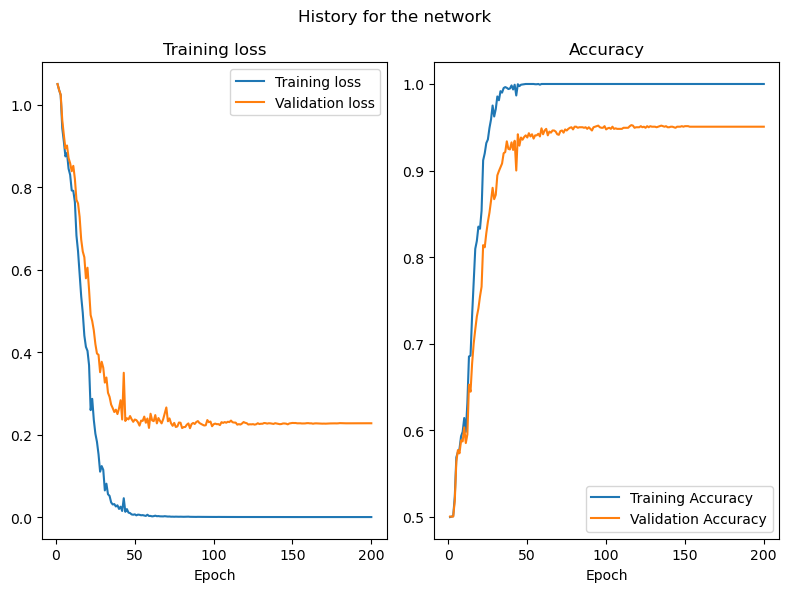

In [10]:
x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
y_cls, y_true = dynamic_model.evaluate(test_loader)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_cls))

[[785  15   0   0]
 [ 29 519  12   0]
 [ 15   8 201   0]
 [  0   0   0  16]]


In [20]:
# torch.save(dynamic_model, 'double_cnn_test.pth')
# loaded_model = torch.load('double_cnn_test.pth')

In [12]:
from sklearn.metrics import classification_report
dynamic_model.eval()
y_true = []
y_cls = []
with torch.no_grad():  # Disable gradient computation during validation
    for i, (x_minibatch, y_true_batch) in enumerate(test_loader):
        y_pred = dynamic_model(x_minibatch)
        y_cls_batch = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
        y_true.append(y_true_batch.tolist())
        y_cls.append(y_cls_batch.tolist())
y_true = np.reshape(y_true, -1)
y_cls = np.reshape(y_cls, -1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       800
           1       0.96      0.93      0.94       560
           2       0.94      0.90      0.92       224
           3       1.00      1.00      1.00        16

    accuracy                           0.95      1600
   macro avg       0.96      0.95      0.96      1600
weighted avg       0.95      0.95      0.95      1600



In [13]:
dynamic_model_2 = functions.custom_ConvNet(
    input_channels = 1,
    output_size = 4,
    n_conv_layers1 = 5,
    n_filters1 = 8,
    kernel_size1 = 6,
    n_dense_layers = 6,
    n_dense_initial_nodes = 2**10,
    n_conv_layers2 = 0,
    n_filters2 = 0, 
    kernel_size2 = 0,
    operation_and_factor_filter_size=('*', 2),
    operation_and_factor_dense_network=('/', 2),
    dropout_rate=0.1,
    pooling = [2,2],
    nb_pooling_layers=2,
    activation_function = F.leaky_relu,
    )

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)
dynamic_model_2.apply(init_weights)

criterion = FocalLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dynamic_model_2.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)
early_stopper = functions.EarlyStopper(dynamic_model_2, patience=5, min_delta=0.05)

loss_training_hist_2, loss_val_hist_2, training_acc_hist_2, val_acc_hist_2 = functions.train_network(dynamic_model_2, train_loader, criterion, optimizer, num_epochs, lr_scheduler, test_loader, device, early_stopper=early_stopper)

Size last layer before output: 64
Device used for training: cpu
Epoch [1/200], Val. Loss: 1.0419, Val. Acc: 0.5008
Epoch [2/200], Val. Loss: 1.0314, Val. Acc: 0.4997
Epoch [3/200], Val. Loss: 0.9705, Val. Acc: 0.5343
Epoch [4/200], Val. Loss: 0.9460, Val. Acc: 0.5401
Epoch [5/200], Val. Loss: 0.9852, Val. Acc: 0.5578
Epoch [6/200], Val. Loss: 0.9042, Val. Acc: 0.5509
Epoch [7/200], Val. Loss: 0.8898, Val. Acc: 0.5686
Epoch [8/200], Val. Loss: 0.8729, Val. Acc: 0.5747
Epoch [9/200], Val. Loss: 0.8608, Val. Acc: 0.5838
Epoch [10/200], Val. Loss: 0.8383, Val. Acc: 0.6117
Epoch [11/200], Val. Loss: 0.8517, Val. Acc: 0.6009
Epoch [12/200], Val. Loss: 0.8079, Val. Acc: 0.6438
Epoch [13/200], Val. Loss: 0.7673, Val. Acc: 0.6704
Epoch [14/200], Val. Loss: 0.7204, Val. Acc: 0.6980
Epoch [15/200], Val. Loss: 0.6871, Val. Acc: 0.7295
Epoch [16/200], Val. Loss: 0.6683, Val. Acc: 0.7381
Epoch [17/200], Val. Loss: 0.6381, Val. Acc: 0.7644
Epoch [18/200], Val. Loss: 0.6042, Val. Acc: 0.7940
Epoch [19

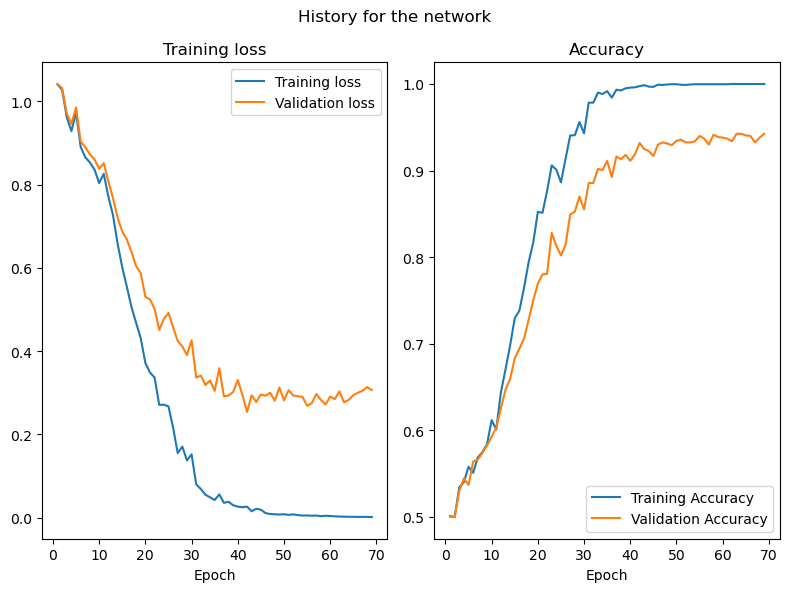

In [14]:
x_epochs = np.linspace(1, len(loss_training_hist_2), len(loss_training_hist_2))
fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].plot(x_epochs, loss_training_hist_2, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist_2, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist_2, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist_2, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
y_cls, y_true = dynamic_model_2.evaluate(test_loader)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_cls))

[[771  28   1   0]
 [ 30 522   8   0]
 [  9  15 200   0]
 [  1   0   0  15]]


In [16]:
from sklearn.metrics import classification_report
dynamic_model_2.eval()
y_true = []
y_cls = []
with torch.no_grad():  # Disable gradient computation during validation
    for i, (x_minibatch, y_true_batch) in enumerate(test_loader):
        y_pred = dynamic_model_2(x_minibatch)
        y_cls_batch = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
        y_true.append(y_true_batch.tolist())
        y_cls.append(y_cls_batch.tolist())
y_true = np.reshape(y_true, -1)
y_cls = np.reshape(y_cls, -1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       800
           1       0.92      0.93      0.93       560
           2       0.96      0.89      0.92       224
           3       1.00      0.94      0.97        16

    accuracy                           0.94      1600
   macro avg       0.96      0.93      0.94      1600
weighted avg       0.94      0.94      0.94      1600



In [22]:
torch.save(dynamic_model, 'single_cnn_test.pth')

In [23]:
loaded_model = torch.load('single_cnn_test.pth')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)
early_stopper = functions.EarlyStopper(loaded_model, patience=5, min_delta=0.05)

loss_training_hist_3, loss_val_hist_3, training_acc_hist_3, val_acc_hist_3 = functions.train_network(loaded_model, train_loader, criterion, optimizer, num_epochs, lr_scheduler, test_loader, device, early_stopper=early_stopper)

Device used for training: cpu
Epoch [1/200], Val. Loss: 0.8812, Val. Acc: 0.5879
Epoch [2/200], Val. Loss: 0.7371, Val. Acc: 0.6933
Epoch [3/200], Val. Loss: 0.5743, Val. Acc: 0.8523
Epoch [4/200], Val. Loss: 0.4953, Val. Acc: 0.8999
Epoch [5/200], Val. Loss: 0.3458, Val. Acc: 0.9665
Epoch [6/200], Val. Loss: 0.2403, Val. Acc: 0.9809
Epoch [7/200], Val. Loss: 0.2312, Val. Acc: 0.9873
Epoch [8/200], Val. Loss: 0.1895, Val. Acc: 0.9972
Epoch [9/200], Val. Loss: 0.1887, Val. Acc: 0.9981
Epoch [10/200], Val. Loss: 0.1885, Val. Acc: 0.9981
Epoch [11/200], Val. Loss: 0.2620, Val. Acc: 0.9942
Epoch [12/200], Val. Loss: 0.1342, Val. Acc: 0.9994
Epoch [13/200], Val. Loss: 0.1353, Val. Acc: 0.9981
Epoch [14/200], Val. Loss: 0.1938, Val. Acc: 0.9981
Epoch [15/200], Val. Loss: 0.2503, Val. Acc: 0.9992
Epoch [16/200], Val. Loss: 0.1643, Val. Acc: 1.0000
Epoch [17/200], Val. Loss: 0.1644, Val. Acc: 0.9997
Epoch [18/200], Val. Loss: 0.1422, Val. Acc: 1.0000
Epoch [19/200], Val. Loss: 0.1290, Val. Acc

KeyboardInterrupt: 

In [25]:
y_cls, y_true = loaded_model.evaluate(test_loader)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_cls))

[[787  11   2   0]
 [ 11 547   2   0]
 [  5  11 208   0]
 [  0   0   0  16]]


In [24]:
from sklearn.metrics import classification_report
loaded_model.eval()
y_true = []
y_cls = []
with torch.no_grad():  # Disable gradient computation during validation
    for i, (x_minibatch, y_true_batch) in enumerate(test_loader):
        y_pred = loaded_model(x_minibatch)
        y_cls_batch = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
        y_true.append(y_true_batch.tolist())
        y_cls.append(y_cls_batch.tolist())
y_true = np.reshape(y_true, -1)
y_cls = np.reshape(y_cls, -1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       800
           1       0.96      0.98      0.97       560
           2       0.98      0.93      0.95       224
           3       1.00      1.00      1.00        16

    accuracy                           0.97      1600
   macro avg       0.98      0.97      0.98      1600
weighted avg       0.97      0.97      0.97      1600

